In [1]:
from sklearn.model_selection import StratifiedShuffleSplit
import numpy as np
import os
import matplotlib.pyplot as plt

# load data and labels
#os.chdir('/rsrch1/bcb/Imaging-Genomics_SIBL/DONNIE_KIM/Brachy_deep_learning/IDH_Prediction/data/pre_processed_data_1p_19q_balanced')
origdir = os.getcwd()
basedir = os.path.abspath(os.path.join(origdir,'..','..'))
normdir = os.path.join(basedir,'data','normalized_data_n4')

#save_dir = '/rsrch1/bcb/Imaging-Genomics_SIBL/DONNIE_KIM/Brachy_deep_learning/IDH_Prediction/data/data_splitted_balanced_20/'
savedir = os.path.join(basedir,'data','data_split_n4')
if not os.path.exists(savedir):
    os.makedirs(savedir)

train_dir = os.path.join(savedir,'train')
val_dir = os.path.join(savedir,'val')
test_dir = os.path.join(savedir,'test')

if not os.path.exists(train_dir):
    os.makedirs(train_dir)
if not os.path.exists(val_dir):
    os.makedirs(val_dir)
if not os.path.exists(test_dir):
    os.makedirs(test_dir)
    
slices_FLAIR = np.load(os.path.join(normdir,'slices_FLAIR.npy'))
slices_T2 = np.load(os.path.join(normdir,'slices_T2.npy'))
slices_T1 = np.load(os.path.join(normdir,'slices_T1.npy'))
slices_T1post = np.load(os.path.join(normdir,'slices_T1post.npy'))
slices_mask = np.load(os.path.join(normdir,'slices_mask.npy'))

label_1p19q = np.load(os.path.join(normdir,'label_1p19q.npy'))
label_age = np.load(os.path.join(normdir,'label_age.npy'))
label_KPS = np.load(os.path.join(normdir,'label_KPS.npy'))
label_gender = np.load(os.path.join(normdir,'label_gender.npy'))
label_IDH1 = np.load(os.path.join(normdir,'label_IDH1.npy')) 
label_OS = np.load(os.path.join(normdir,'label_OS.npy'))

label_id = np.load(os.path.join(normdir,'label_id.npy'))
label_idstr = np.load(os.path.join(normdir,'label_idstr.npy'))

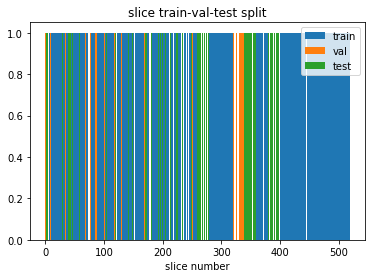

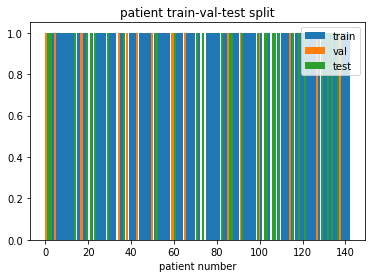

In [2]:
#Split the data in 70/10/20 manner among train/val/test

random_seed = 42

sss = StratifiedShuffleSplit(n_splits =1, test_size = 0.2, random_state = random_seed)

label_id_comb = np.hstack((label_1p19q.reshape(-1,1),label_id.reshape(-1,1),np.arange(len(label_1p19q)).reshape(-1,1)))
u_label_id_comb = np.unique(label_id_comb[:,[0,1]],axis=0)

[train_test_split] = sss.split(u_label_id_comb[:,1], u_label_id_comb[:,0])
tt0 = train_test_split[0]
tt1 = train_test_split[1]

# split between train and val
random_seed2 = 32

sss2 = StratifiedShuffleSplit(n_splits =1, test_size = 0.125)

[train_val_split] = sss2.split(u_label_id_comb[tt0,1], u_label_id_comb[tt0,0])
tv0 = train_val_split[0]
tv1 = train_val_split[1]

# separate out the training and validation data from testing
tv_mask = np.in1d(label_id_comb[:,1],tt0)
tv_label_id_comb = label_id_comb[tv_mask,:]

# turn into the indices
trainMask = np.in1d(tv_label_id_comb[:,1],tt0[tv0])
trainIdxs = np.int64(tv_label_id_comb[trainMask,2])
valMask = np.in1d(tv_label_id_comb[:,1],tt0[tv1])
valIdxs = np.int64(tv_label_id_comb[valMask,2])
testMask = np.in1d(label_id_comb[:,1],tt1)
testIdxs = np.int64(label_id_comb[testMask,2])

# initialize the output arrays for slices
dims = [x for x in slices_FLAIR[0,:,:,:].shape]
(train_FLAIR,train_T2,train_T1,train_T1post,train_mask) = (np.empty(np.append([len(trainIdxs)],dims)) for i in range(5))
(val_FLAIR,val_T2,val_T1,val_T1post,val_mask) = (np.empty(np.append([len(valIdxs)],dims)) for i in range(5))
(test_FLAIR,test_T2,test_T1,test_T1post,test_mask) = (np.empty(np.append([len(testIdxs)],dims)) for i in range(5))

# initialize the output arrays for data
(train_1p19q,train_age,train_KPS,train_gender,train_OS,train_IDH1,train_id) = (np.empty(len(trainIdxs)) for i in range(7))
(val_1p19q,val_age,val_KPS,val_gender,val_OS,val_IDH1,val_id) = (np.empty(len(valIdxs)) for i in range(7))
(test_1p19q,test_age,test_KPS,test_gender,test_OS,test_IDH1,test_id) = (np.empty(len(testIdxs)) for i in range(7))

train_idstr = np.empty(len(trainIdxs),dtype=object) 
val_idstr = np.empty(len(valIdxs),dtype=object) 
test_idstr = np.empty(len(testIdxs),dtype=object) 

# arrange the data into training testing and validation
#for tr_i,    vl_i,    ts_i in zip(trainIdxs,valIdxs,testIdxs):
#    train_FLAIR,  val_FLAIR,  test_FLAIR  = slices_FLAIR[tr_i],  slices_FLAIR[vl_i],  slices_FLAIR[ts_i]
#    train_T2,     val_T2,     test_T2     = slices_T2[tr_i],     slices_T2[vl_i],     slices_T2[ts_i]
#    train_T1,     val_T1,     test_T1     = slices_T1[tr_i],     slices_T1[vl_i],     slices_T1[ts_i]
#    train_T1post, val_T1post, test_T1post = slices_T1post[tr_i], slices_T1post[vl_i], slices_T1post[ts_i]

# for individual members you can't use a zipped loop
for tr_o in range(len(trainIdxs)):
    tr_i = trainIdxs[tr_o]
    train_FLAIR[tr_o,:,:,:]  = slices_FLAIR[tr_i,:,:,:]
    train_T2[tr_o,:,:,:]     = slices_T2[tr_i,:,:,:]
    train_T1[tr_o,:,:,:]     = slices_T1[tr_i,:,:,:]
    train_T1post[tr_o,:,:,:] = slices_T1post[tr_i,:,:,:]
    train_mask[tr_o,:,:,:]   = slices_mask[tr_i,:,:,:]
    
    train_1p19q[tr_o]  = label_1p19q[tr_i]
    train_age[tr_o]    = label_age[tr_i]
    train_KPS[tr_o]    = label_KPS[tr_i]
    train_gender[tr_o] = label_gender[tr_i]
    train_OS[tr_o]     = label_OS[tr_i]
    train_IDH1[tr_o]   = label_IDH1[tr_i]
    train_id[tr_o]     = label_id[tr_i]
    train_idstr[tr_o]  = label_idstr[tr_i]

for vl_o in range(len(valIdxs)):
    vl_i = valIdxs[vl_o]
    val_FLAIR[vl_o,:,:,:]  = slices_FLAIR[vl_i,:,:,:]
    val_T2[vl_o,:,:,:]     = slices_T2[vl_i,:,:,:]
    val_T1[vl_o,:,:,:]     = slices_T1[vl_i,:,:,:]
    val_T1post[vl_o,:,:,:] = slices_T1post[vl_i,:,:,:]
    val_mask[vl_o,:,:,:]   = slices_mask[vl_i,:,:,:]
    
    val_1p19q[vl_o]  = label_1p19q[vl_i]
    val_age[vl_o]    = label_age[vl_i]
    val_KPS[vl_o]    = label_KPS[vl_i]
    val_gender[vl_o] = label_gender[vl_i]
    val_OS[vl_o]     = label_OS[vl_i]
    val_IDH1[vl_o]   = label_IDH1[vl_i]
    val_id[vl_o]     = label_id[vl_i]
    val_idstr[vl_o]  = label_idstr[vl_i]

for ts_o in range(len(testIdxs)):
    ts_i = testIdxs[ts_o]
    test_FLAIR[ts_o,:,:,:]  = slices_FLAIR[ts_i,:,:,:]
    test_T2[ts_o,:,:,:]     = slices_T2[ts_i,:,:,:]
    test_T1[ts_o,:,:,:]     = slices_T1[ts_i,:,:,:]
    test_T1post[ts_o,:,:,:] = slices_T1post[ts_i,:,:,:]
    test_mask[ts_o,:,:,:]   = slices_mask[ts_i,:,:,:]
    
    test_1p19q[ts_o]  = label_1p19q[ts_i]
    test_age[ts_o]    = label_age[ts_i]
    test_KPS[ts_o]    = label_KPS[ts_i]
    test_gender[ts_o] = label_gender[ts_i]
    test_OS[ts_o]     = label_OS[ts_i]
    test_IDH1[ts_o]   = label_IDH1[ts_i]
    test_id[ts_o]     = label_id[ts_i]
    test_idstr[ts_o]  = label_idstr[ts_i]
    #for tr_o,    vl_o,    ts_o in zip(range(len(trainIdxs)),range(len(valIdxs)),range(len(testIdxs))):
#    tr_i, vl_i, ts_i  =   trainIdxs[tr_o],valIdxs[vl_o],testIdxs[ts_o]
#    train_1p19q[tr_o],  val_1p19q[vl_o],  test_1p19q[ts_o]  = label_1p19q[tr_i],  label_1p19q[vl_i],  label_1p19q[ts_i]
#    train_age[tr_o],    val_age[vl_o],    test_age[ts_o]    = label_age[tr_i],    label_age[vl_i],    label_age[ts_i]
#    train_KPS[tr_o],    val_KPS[vl_o],    test_KPS[ts_o]    = label_KPS[tr_i],    label_KPS[vl_i],    label_KPS[ts_i]
#    train_gender[tr_o], val_gender[vl_o], test_gender[ts_o] = label_gender[tr_i], label_gender[vl_i], label_gender[ts_i]
#    train_OS[tr_o],     val_OS[vl_o],     test_OS[ts_o]     = label_OS[tr_i],     label_OS[vl_i],     label_OS[ts_i]
#    train_IDH1[tr_o],   val_IDH1[vl_o],   test_IDH1[ts_o]   = label_IDH1[tr_i],   label_IDH1[vl_i],   label_IDH1[ts_i]
#    train_id[tr_o],     val_id[vl_o],     test_id[ts_o]     = label_id[tr_i],     label_id[vl_i],     label_id[ts_i]
#    train_idstr[tr_o],  val_idstr[vl_o],  test_idstr[ts_o]  = label_idstr[tr_i],  label_idstr[vl_i],  label_idstr[ts_i]



bins = len(label_id_comb[:,1])
plt.hist(trainIdxs, bins, stacked = True, label='train')
plt.hist(valIdxs,   bins, stacked = True, label='val')
plt.hist(testIdxs,  bins, stacked = True, label='test')
plt.legend(loc = 'upper right')
plt.xlabel('slice number')
plt.title('slice train-val-test split')
plt.show()

bins = np.int64(np.concatenate((train_id,val_id,test_id)).max()+1)
plt.hist(np.unique(train_id), bins, stacked = True, label='train')
plt.hist(np.unique(val_id),   bins, stacked = True, label='val')
plt.hist(np.unique(test_id),  bins, stacked = True, label='test')
plt.legend(loc = 'upper right')
plt.title('patient train-val-test split')
plt.xlabel('patient number')
plt.show()

In [3]:
#os.chdir(train_dir)
np.save(os.path.join(train_dir,'train_FLAIR.npy'), train_FLAIR)
np.save(os.path.join(train_dir,'train_T2.npy'), train_T2)
np.save(os.path.join(train_dir,'train_T1.npy'), train_T1)
np.save(os.path.join(train_dir,'train_T1post.npy'), train_T1post)
np.save(os.path.join(train_dir,'train_mask.npy'), train_mask)

np.save(os.path.join(train_dir,'train_age.npy'),train_age)
np.save(os.path.join(train_dir,'train_IDH1.npy'), train_IDH1)
np.save(os.path.join(train_dir,'train_1p19q.npy'), train_1p19q)
np.save(os.path.join(train_dir,'train_OS.npy'), train_OS)
np.save(os.path.join(train_dir,'train_gender.npy'), train_gender)
np.save(os.path.join(train_dir,'train_KPS.npy'), train_KPS)
np.save(os.path.join(train_dir,'train_id.npy'), train_id)
np.save(os.path.join(train_dir,'train_idstr.npy'), train_idstr)

#os.chdir(val_dir)
np.save(os.path.join(val_dir,'val_FLAIR.npy'), val_FLAIR)
np.save(os.path.join(val_dir,'val_T2.npy'), val_T2)
np.save(os.path.join(val_dir,'val_T1.npy'), val_T1)
np.save(os.path.join(val_dir,'val_T1post.npy'), val_T1post)
np.save(os.path.join(val_dir,'val_mask.npy'), val_mask)

np.save(os.path.join(val_dir,'val_age.npy'),val_age)
np.save(os.path.join(val_dir,'val_IDH1.npy'), val_IDH1)
np.save(os.path.join(val_dir,'val_1p19q.npy'), val_1p19q)
np.save(os.path.join(val_dir,'val_OS.npy'), val_OS)
np.save(os.path.join(val_dir,'val_gender.npy'), val_gender)
np.save(os.path.join(val_dir,'val_KPS.npy'), val_KPS)
np.save(os.path.join(val_dir,'val_id.npy'), val_id)
np.save(os.path.join(val_dir,'val_idstr.npy'), val_idstr)

#os.chdir(test_dir)
np.save(os.path.join(test_dir,'test_FLAIR.npy'), test_FLAIR)
np.save(os.path.join(test_dir,'test_T2.npy'), test_T2)
np.save(os.path.join(test_dir,'test_T1.npy'), test_T1)
np.save(os.path.join(test_dir,'test_T1post.npy'), test_T1post)
np.save(os.path.join(test_dir,'test_mask.npy'), test_mask)

np.save(os.path.join(test_dir,'test_age.npy'),test_age)
np.save(os.path.join(test_dir,'test_IDH1.npy'), test_IDH1)
np.save(os.path.join(test_dir,'test_1p19q.npy'), test_1p19q)
np.save(os.path.join(test_dir,'test_OS.npy'), test_OS)
np.save(os.path.join(test_dir,'test_gender.npy'), test_gender)
np.save(os.path.join(test_dir,'test_KPS.npy'), test_KPS)
np.save(os.path.join(test_dir,'test_id.npy'), test_id)
np.save(os.path.join(test_dir,'test_idstr.npy'), test_idstr)

In [3]:
import nibabel as nib
import numpy as np
func_img = nib.load(r"C:\Users\ncwang\Documents\Rao_lab\1p19q Project\data\N4_corrected_image_data\TCGA-CS-4942\t1.nii.gz")
header = func_img.header
print(header)
print(header.get_zooms())

<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b'r'
dim_info        : 0
dim             : [  3 240 240 155   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : float32
bitpix          : 32
slice_start     : 0
pixdim          : [1. 1. 1. 1. 0. 0. 0. 0.]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 2
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b''
aux_file        : b''
qform_code      : aligned
sform_code      : scanner
quatern_b       : 0.0
quatern_c       : 0.0
quatern_d       : 1.0
qoffset_x       : -0.0
qoffset_y       : 239.0
qoffset_z       : 0.0
srow_x          : [-1.  0.  0. -0.]
srow_y         

In [ ]:
func_img.